# EDA for FACEIT Match Data

Testing these three hypotheses:

**H1**: entry_win_rate is positively associated with winning the match
- Testing: entry_win_rate vs win/loss (result)
- Variables: entry_rate, entry_win_rate, result

**H2**: fk_fd_diff is positively associated with round_difference  
- Testing: fk_fd_diff vs round_difference
- Variables: fk_fd_diff, round_difference

**H3**: Entry signals add predictive value beyond KD when controls are included
- Testing: Compare models with/without entry features
- Base controls: KD + ADR + KR + map + overtime
- Entry features: entry_rate, entry_win_rate, first_kills, first_deaths

This EDA prepares the data and shows correlations/visualizations to test these hypotheses.


In [14]:
# 1) Setup: Libraries and Plot Settings
import warnings
warnings.filterwarnings("ignore")

import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression

sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)
pd.set_option("display.max_columns", 200)
np.random.seed(42)

DATA_PATH = "my_faceit_matches.csv"


## Loading the data

Just loading the CSV file with my match data. Each row is one match, has stuff like kills, deaths, ADR, entry stats, whether I won, what map, etc. Need to parse the date column so I can look at trends over time.


In [15]:
# 2) Data Loading
assert os.path.exists(DATA_PATH), f"Expected data file not found: {DATA_PATH}"

df = pd.read_csv(DATA_PATH)

# Parse date column if present
if "date" in df.columns:
    df["date"] = pd.to_datetime(df["date"], errors="coerce")

print("Shape:", df.shape)
df.head()


Shape: (484, 22)


,date,map,result,kills,deaths,assists,hs,hs_percent,kd,kr,mvps,adr,first_kills,first_deaths,entry_count,entry_wins,rounds_played,overtime,match_duration_min,my_team_score,enemy_team_score,round_difference
0,2025-11-07 14:31:41,de_mirage,Loss,4,21,7,1,25.0,0.19,0.19,0,47.9,2,6,8,2,21,False,35.8,13,8,5
1,2025-11-07 12:15:46,de_dust2,Loss,18,18,8,11,61.0,1.00,0.82,1,98.6,2,3,5,2,22,False,33.1,13,9,4
2,2025-11-07 11:43:51,de_train,Loss,9,15,9,5,56.0,0.60,0.47,1,76.3,0,2,2,0,19,False,27.2,13,6,7
3,2025-11-06 21:31:54,de_mirage,Loss,15,18,11,9,60.0,0.83,0.62,1,69.2,2,5,7,2,24,False,38.1,13,11,2
4,2025-11-06 18:40:52,de_dust2,Win,20,16,6,13,65.0,1.25,0.87,3,97.4,4,0,4,4,23,False,33.3,10,13,-3


## Cleaning the data

Converting everything to the right types. Making a binary win column (1 if win, 0 if loss) since that's what I need for the analysis. Also making an overtime flag. Checking for missing values too.


In [16]:
# 3) Type Casting and Missingness Summary
numeric_like = [
    "kills","deaths","assists","hs","hs_percent","kd","kr","mvps",
    "adr","first_kills","first_deaths","entry_count","entry_wins",
    "rounds_played","match_duration_min","my_team_score","enemy_team_score",
    "round_difference"
]
for col in numeric_like:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

# Normalize result variable and add binary win
if "result" in df.columns:
    df["result"] = df["result"].astype(str).str.strip().str.title()
    df["win"] = (df["result"] == "Win").astype(int)

# Overtime binary flag
if "overtime" in df.columns:
    df["overtime_flag"] = df["overtime"].astype(str).str.lower().isin(["true","1","yes"]).astype(int)

print(df.info())
print("\nMissing values (count):\n", df.isna().sum().sort_values(ascending=False))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 484 entries, 0 to 483
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   date                484 non-null    datetime64[ns]
 1   map                 484 non-null    object        
 2   result              484 non-null    object        
 3   kills               484 non-null    int64         
 4   deaths              484 non-null    int64         
 5   assists             484 non-null    int64         
 6   hs                  484 non-null    int64         
 7   hs_percent          484 non-null    float64       
 8   kd                  484 non-null    float64       
 9   kr                  484 non-null    float64       
 10  mvps                484 non-null    int64         
 11  adr                 484 non-null    float64       
 12  first_kills         484 non-null    int64         
 13  first_deaths        484 non-null    int64         

## Creating features for hypothesis testing

Making the variables I need to test my hypotheses:
- entry_rate = entry_count / rounds_played (how often I entry)
- entry_win_rate = entry_wins / entry_count (how good I am at entries). If entry_count = 0 (no entry attempts), impute with mean entry_win_rate
- fk_fd_diff = first_kills - first_deaths (first engagement performance)

Also extracting year/month from dates for time analysis.


In [17]:
# 4) Derived Features (aligned with README)
# entry_rate = entry_count / rounds_played
if set(["entry_count","rounds_played"]).issubset(df.columns):
    df["entry_rate"] = df["entry_count"].div(df["rounds_played"]).replace([np.inf,-np.inf], np.nan)

# entry_win_rate = entry_wins / entry_count
# If entry_count = 0 (no entry attempts), impute with mean entry_win_rate
if set(["entry_wins","entry_count"]).issubset(df.columns):
    # First calculate entry_win_rate for matches with entry_count > 0
    df["entry_win_rate"] = df.apply(lambda r: r["entry_wins"] / r["entry_count"] if r["entry_count"] and r["entry_count"]>0 else np.nan, axis=1)
    # Then impute missing values (entry_count = 0) with mean
    n_missing = df["entry_win_rate"].isna().sum()
    if n_missing > 0:
        mean_ewr = df["entry_win_rate"].mean()
        df["entry_win_rate"] = df["entry_win_rate"].fillna(mean_ewr)
        print(f"Imputed {n_missing} missing entry_win_rate values (entry_count=0) with mean: {mean_ewr:.4f}")

# fk_fd_diff = first_kills - first_deaths
if set(["first_kills","first_deaths"]).issubset(df.columns):
    df["fk_fd_diff"] = df["first_kills"] - df["first_deaths"]

# Date derivatives
if "date" in df.columns:
    df["year"] = df["date"].dt.year
    df["month"] = df["date"].dt.to_period("M").dt.to_timestamp()

selected_cols = ["kd","kr","adr","entry_rate","entry_win_rate","fk_fd_diff","round_difference","win","overtime_flag"]
print("Available derived columns:", [c for c in selected_cols if c in df.columns])
df.head()


Imputed 5 missing entry_win_rate values (entry_count=0) with mean: 0.4970
Available derived columns: ['kd', 'kr', 'adr', 'entry_rate', 'entry_win_rate', 'fk_fd_diff', 'round_difference', 'win', 'overtime_flag']


,date,map,result,kills,deaths,assists,hs,hs_percent,kd,kr,mvps,adr,first_kills,first_deaths,entry_count,entry_wins,rounds_played,overtime,match_duration_min,my_team_score,enemy_team_score,round_difference,win,overtime_flag,entry_rate,entry_win_rate,fk_fd_diff,year,month
0,2025-11-07 14:31:41,de_mirage,Loss,4,21,7,1,25.0,0.19,0.19,0,47.9,2,6,8,2,21,False,35.8,13,8,5,0,0,0.380952,0.250000,-4,2025,2025-11-01
1,2025-11-07 12:15:46,de_dust2,Loss,18,18,8,11,61.0,1.00,0.82,1,98.6,2,3,5,2,22,False,33.1,13,9,4,0,0,0.227273,0.400000,-1,2025,2025-11-01
2,2025-11-07 11:43:51,de_train,Loss,9,15,9,5,56.0,0.60,0.47,1,76.3,0,2,2,0,19,False,27.2,13,6,7,0,0,0.105263,0.000000,-2,2025,2025-11-01
3,2025-11-06 21:31:54,de_mirage,Loss,15,18,11,9,60.0,0.83,0.62,1,69.2,2,5,7,2,24,False,38.1,13,11,2,0,0,0.291667,0.285714,-3,2025,2025-11-01
4,2025-11-06 18:40:52,de_dust2,Win,20,16,6,13,65.0,1.25,0.87,3,97.4,4,0,4,4,23,False,33.3,10,13,-3,1,0,0.173913,1.000000,4,2025,2025-11-01


## Basic stats

Just getting mean, std, percentiles for all the variables. Need to see the distributions before testing correlations. Average KD is around 1.1, entry_win_rate is about 0.5, win rate is 50.6% so matchmaking seems balanced.

In [18]:
# 5) Summary
_ = df.describe(percentiles=[.01,.05,.1,.25,.5,.75,.9,.95,.99]).T
print(_)


                    count                           mean                  min  \
date                  484  2025-08-27 03:42:17.256198400  2025-06-19 02:56:26   
kills               484.0                      16.539256                  1.0   
deaths              484.0                       15.92562                  0.0   
assists             484.0                       5.390496                  0.0   
hs                  484.0                       8.830579                  0.0   
hs_percent          484.0                      53.367769                  0.0   
kd                  484.0                       1.107087                 0.06   
kr                  484.0                       0.747417                 0.06   
mvps                484.0                       2.297521                  0.0   
adr                 484.0                      83.513636                 20.7   
first_kills         484.0                       2.477273                  0.0   
first_deaths        484.0   

## Looking at distributions

Plotting histograms to see how each variable is distributed. Need to check if things are normal or skewed since that affects which correlation method to use. Most performance metrics are probably right-skewed (more bad games than great ones).


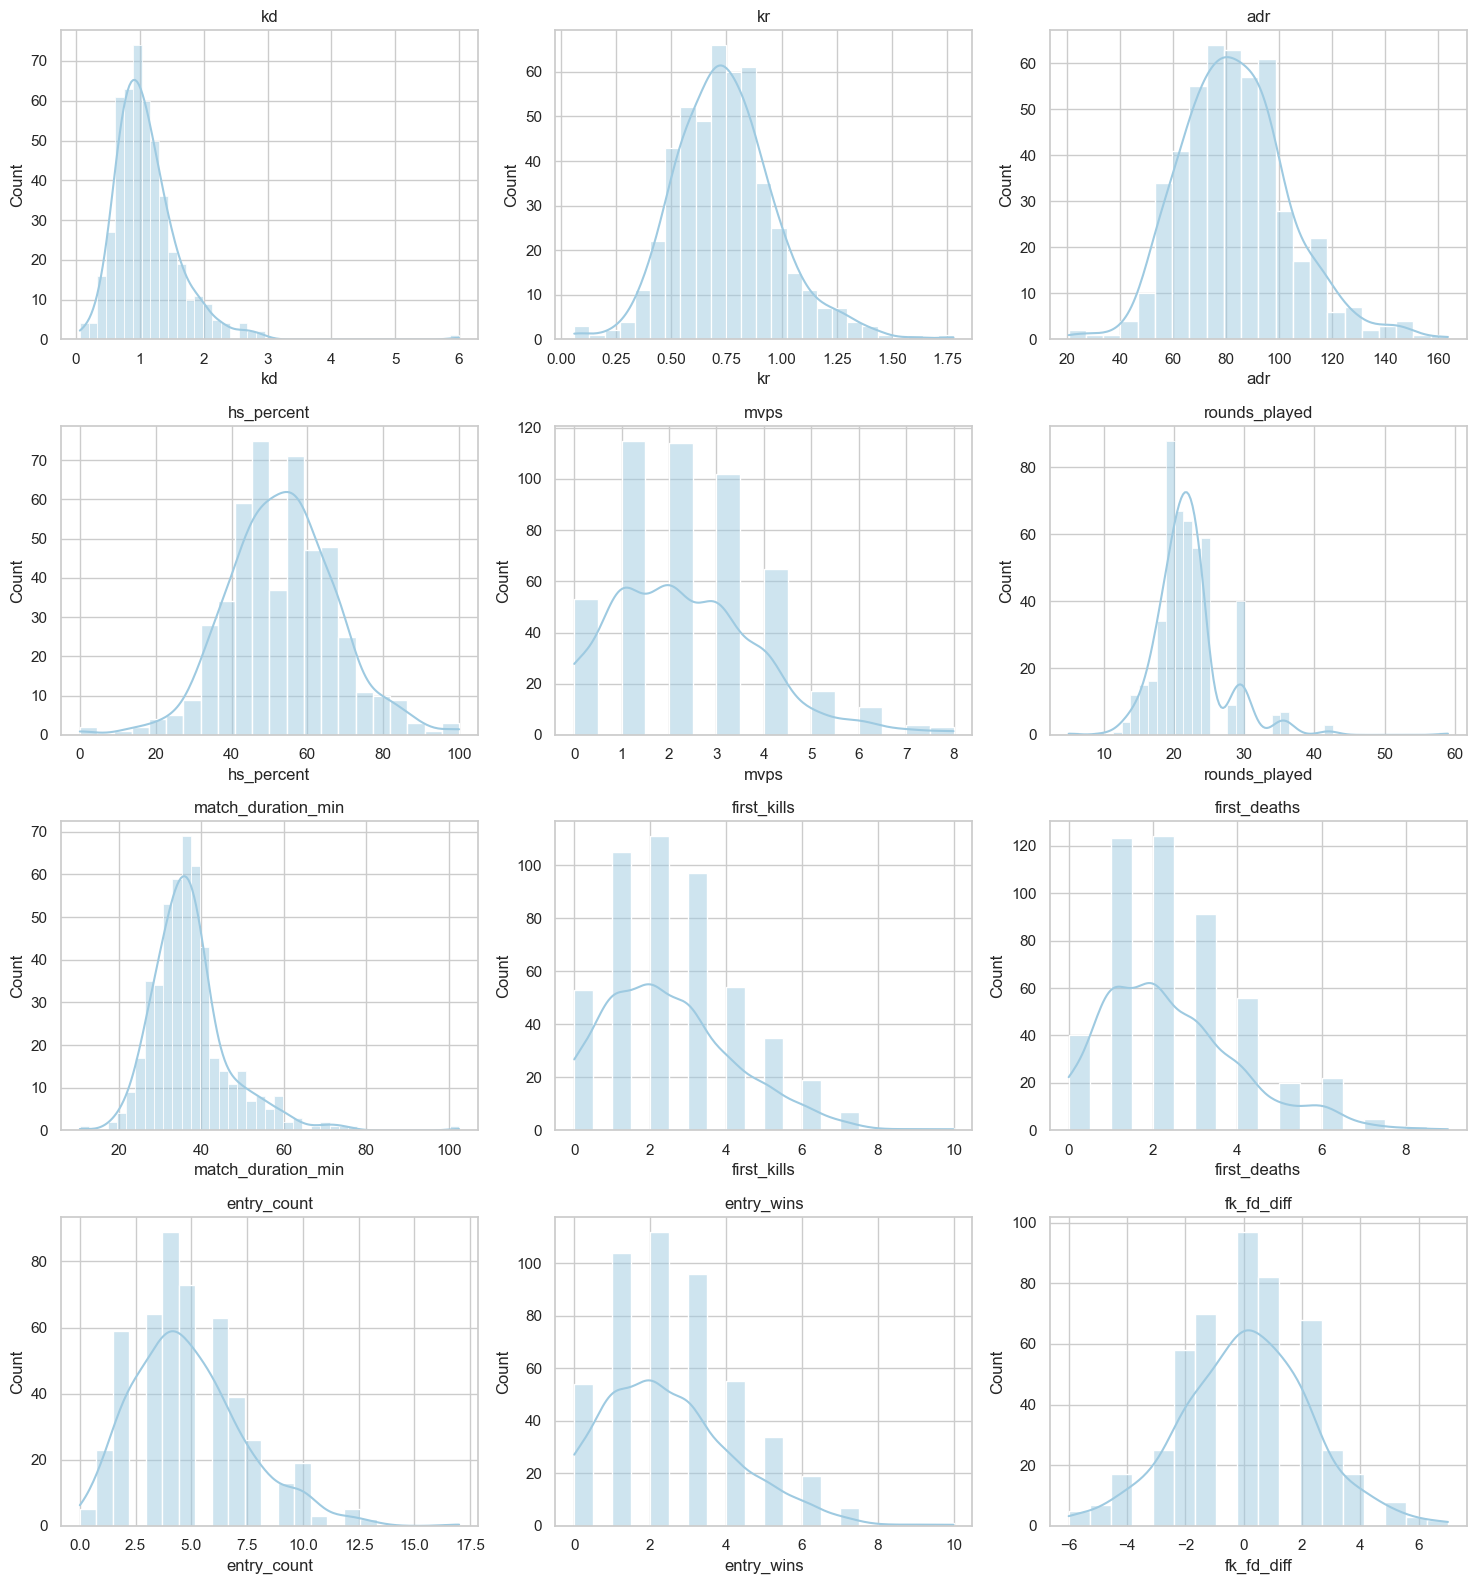

In [19]:
# 6) Univariate Distribution Panel
plot_cols = [
    "kd","kr","adr","hs_percent","mvps","rounds_played",
    "match_duration_min","first_kills","first_deaths","entry_count","entry_wins","fk_fd_diff"
]
plot_cols = [c for c in plot_cols if c in df.columns]

n = len(plot_cols)
cols = 3
rows = int(np.ceil(n/cols)) if n>0 else 0
if n>0:
    fig, axes = plt.subplots(rows, cols, figsize=(cols*5, rows*4))
    axes = axes.flatten()
    for i, c in enumerate(plot_cols):
        sns.histplot(df[c].dropna(), kde=True, ax=axes[i], color="#9ecae1")
        axes[i].set_title(c)
    for j in range(i+1, rows*cols):
        axes[j].axis('off')
    plt.tight_layout()
    plt.show()


## Correlations and Bivariate Relationships
Aligned with the hypotheses, we analyze how KD, ADR, KR and entry-derived features relate to result and round difference.


### Correlation method choice
We use **Pearson** correlation for all hypothesis tests.


Win/loss analysis:
- Correlation matrix shows KD/ADR/KR have strong positive correlations with win (0.47, 0.37, 0.32)
- entry_win_rate has moderate positive correlation with win (0.16)
- fk_fd_diff has positive correlation with win (0.21)

Map analysis (needed for controls in all hypotheses):
- Win rates vary a lot by map (de_train 57%, de_ancient 33%)
- Performance metrics also vary by map
- Will control for map in all hypothesis tests to account for map-specific effects


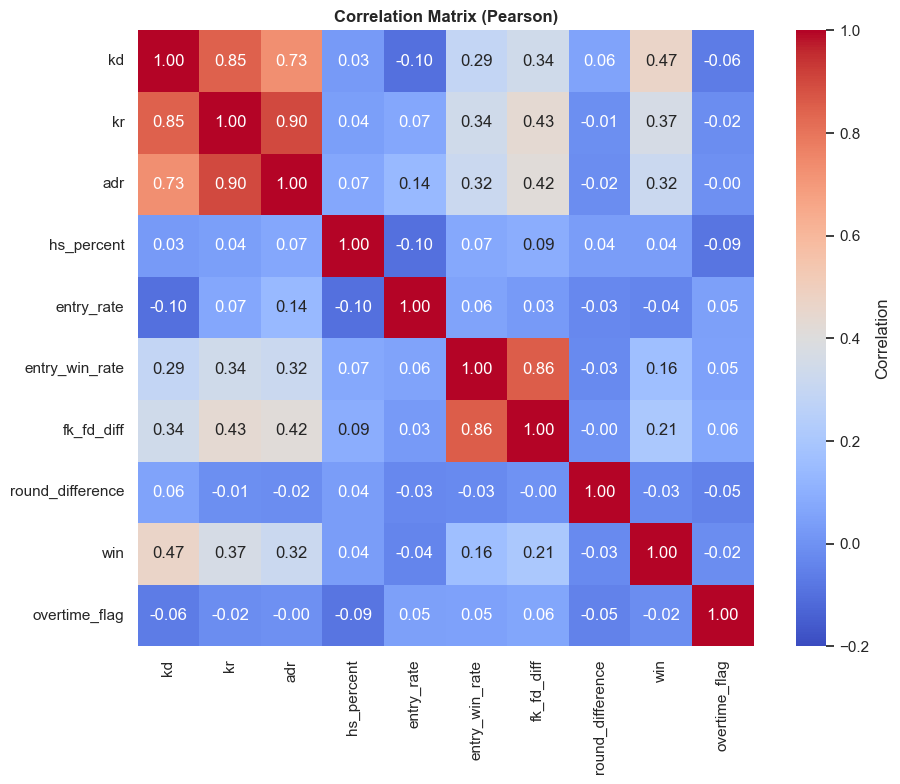

In [20]:
# 7) Correlation Heatmaps (Pearson) and Target Correlations
corr_cols = [
    "kd","kr","adr","hs_percent","entry_rate","entry_win_rate","fk_fd_diff",
    "round_difference","win","overtime_flag"
]
corr_cols = [c for c in corr_cols if c in df.columns]

if len(corr_cols) >= 2:
    num_df = df[corr_cols]

    # Pearson correlation - Blue to red gradient (no white center)
    corr_pearson = num_df.corr(method="pearson", numeric_only=True)
    
    plt.figure(figsize=(10,8))
    sns.heatmap(corr_pearson, annot=True, fmt=".2f", square=True, 
                cmap="coolwarm", vmin=-0.2, vmax=1,
                cbar_kws={"label": "Correlation"})
    plt.title("Correlation Matrix (Pearson)", fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.show()


## Main Findings from Correlation Analysis

Based on the correlation analysis above:

- KD correlates strongest with win (0.47), then KR (0.37), ADR (0.32)
- entry_win_rate correlates with win at 0.16, fk_fd_diff at 0.21 - weaker than KD but still positive
- entry_win_rate and fk_fd_diff are highly correlated (0.86), so they're measuring similar things
- entry_rate doesn't matter much (-0.04), it's about quality not quantity
- Everything has weak correlation with round_difference, probably because that's more team-dependent


Time trends:
- Rolling averages show performance over time (10 match window) - each metric in separate subplot
- Monthly averages show longer-term patterns


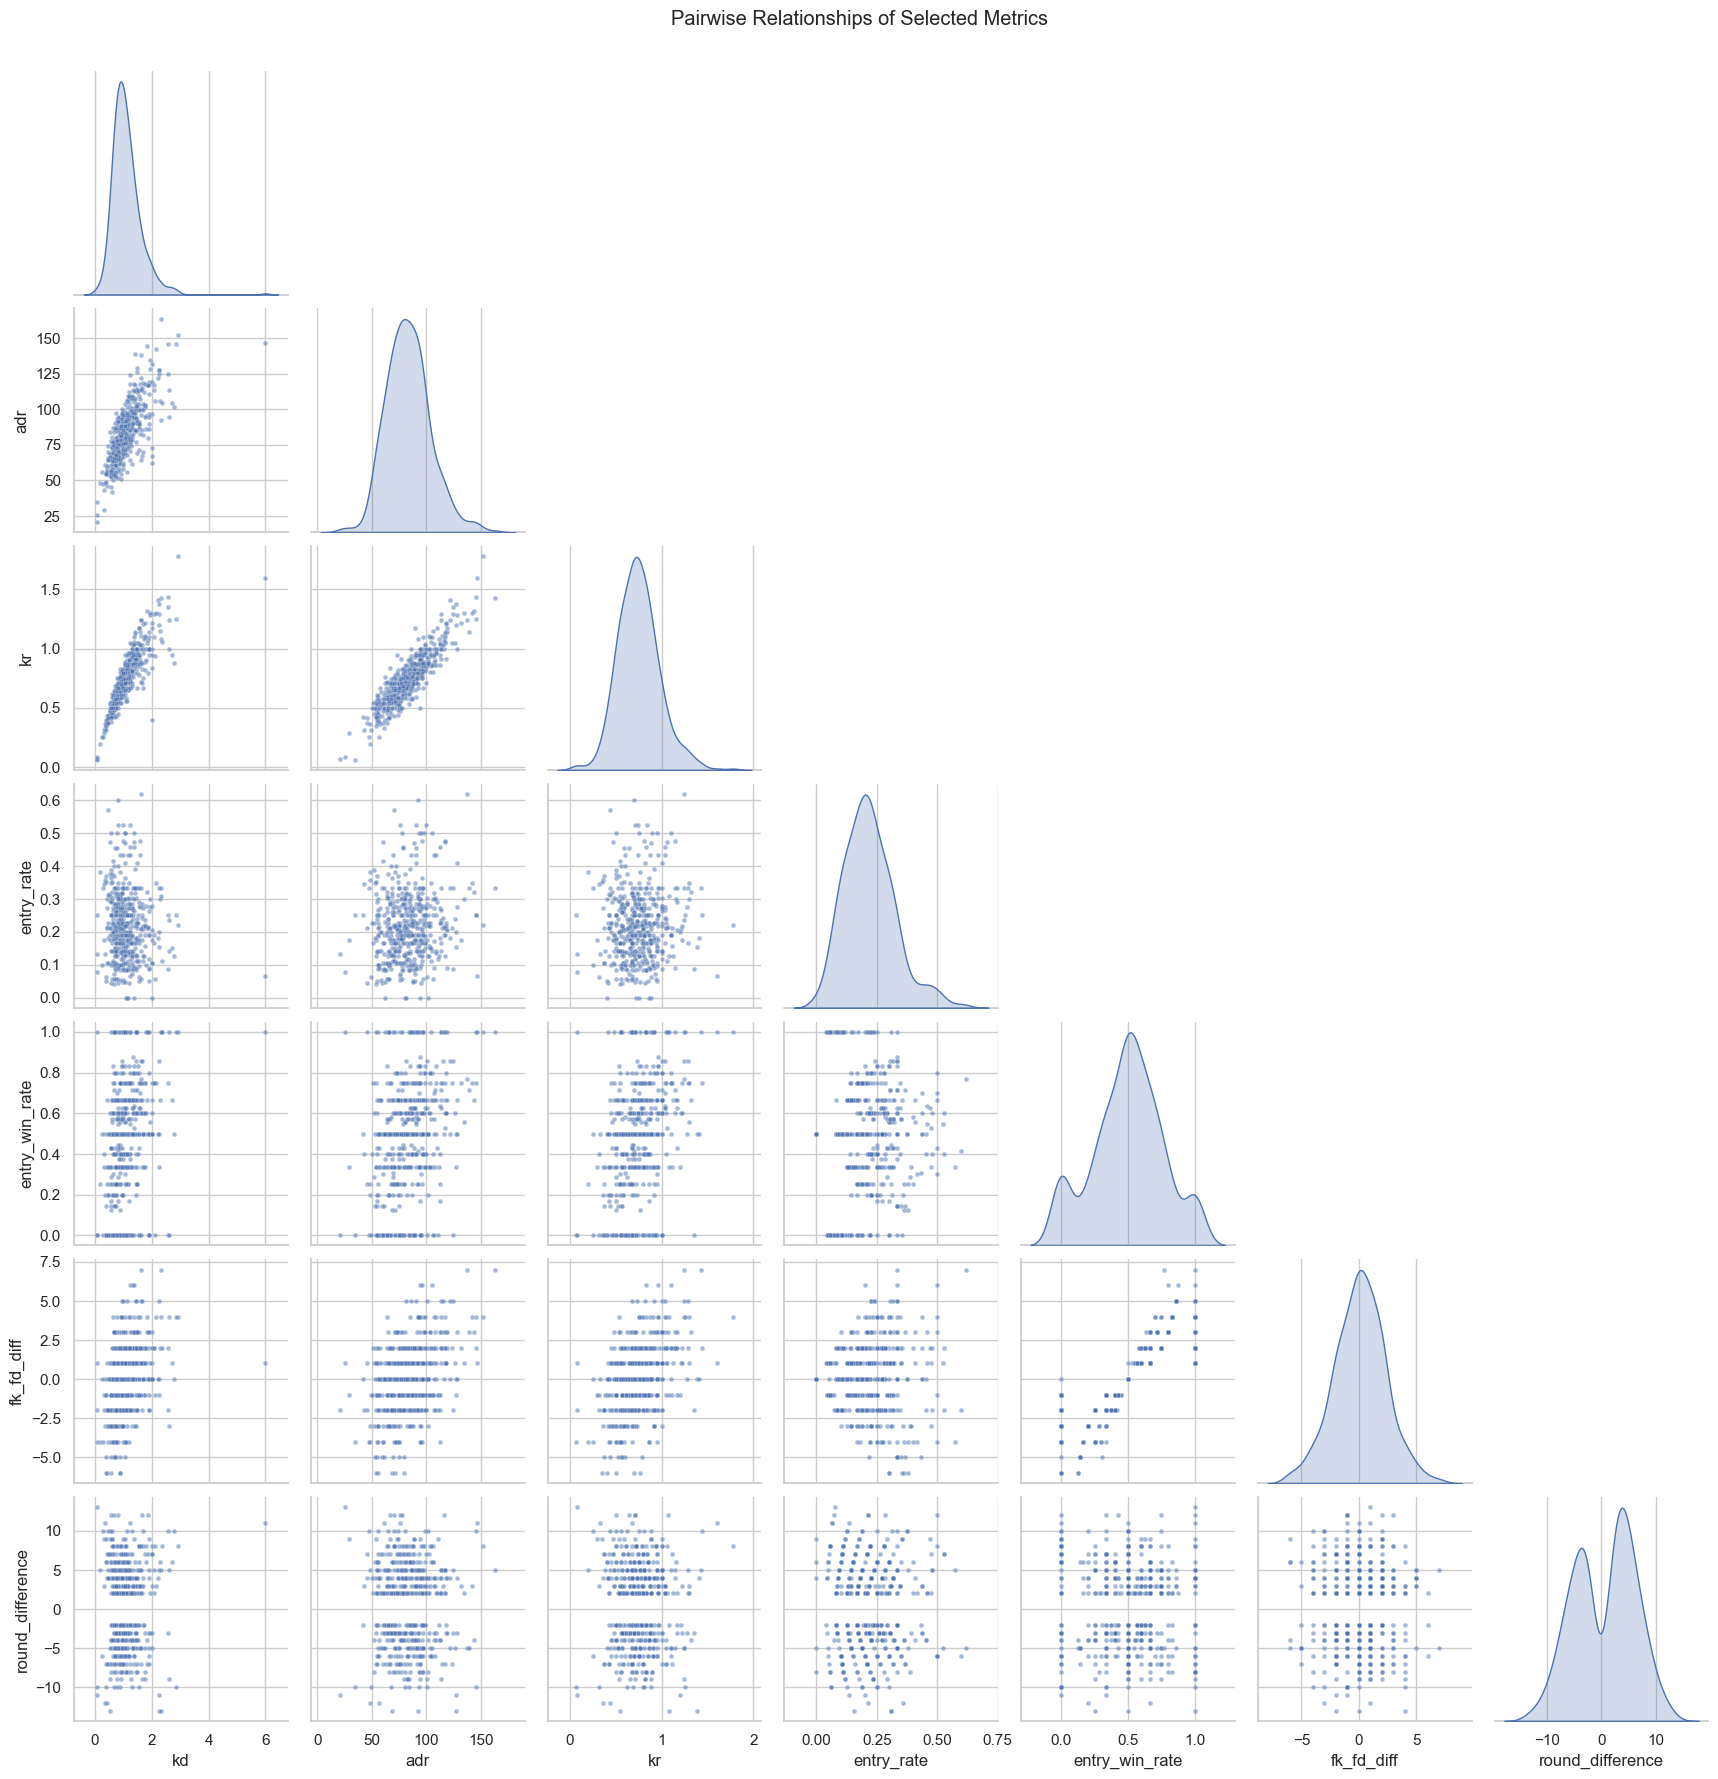

In [21]:
# 8) Pairwise Relationships (Pairplot)

# Pairplot shows all pairwise relationships between metrics
# Diagonal: Distribution of each metric (KDE curves)
# Off-diagonal: Scatter plots showing how two metrics relate
# - Upward line = positive correlation
# - Downward line = negative correlation  
# - Random scatter = no correlation

pair_cols = [c for c in ["kd","adr","kr","entry_rate","entry_win_rate","fk_fd_diff","round_difference"] if c in df.columns]
if len(pair_cols) >= 2:
    plot_df = df[pair_cols].dropna()
    if len(plot_df) > 600:
        plot_df = plot_df.sample(600, random_state=42)
    sns.pairplot(plot_df, corner=True, diag_kind="kde", plot_kws={"alpha":0.5, "s":12})
    plt.suptitle("Pairwise Relationships of Selected Metrics", y=1.02)
    plt.show()


## Result (Win/Loss) and Map Analyses
- Overall win rate
- Win rate and performance by map
- Overtime effect


Overall win rate: 50.62%


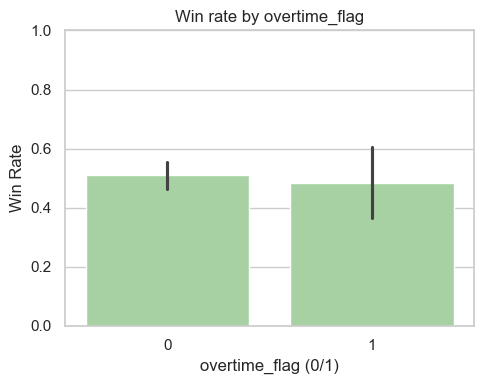

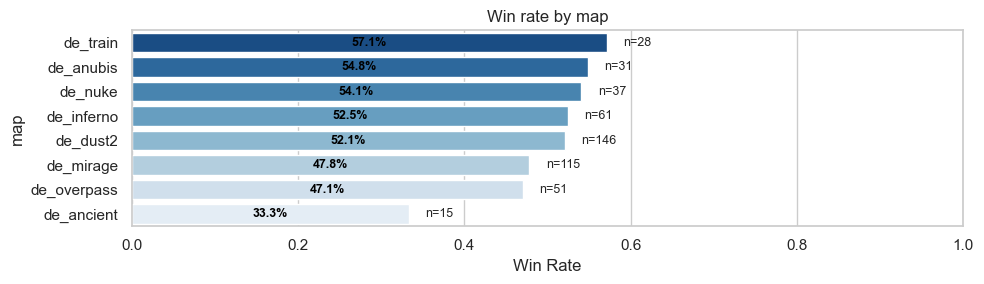

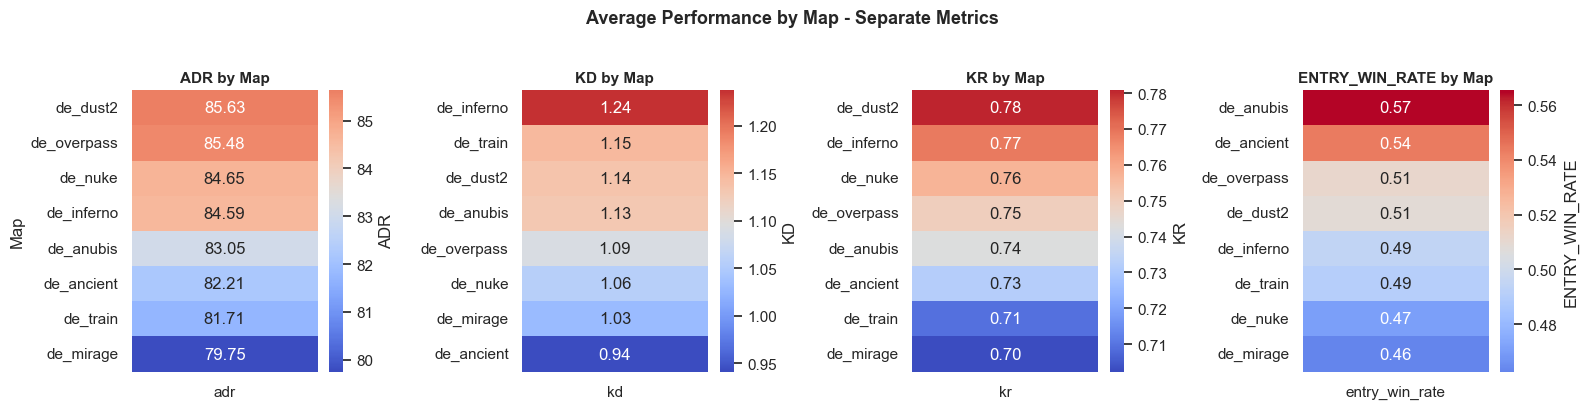

In [22]:
# 9) Overall win rate
if "win" in df.columns:
    win_rate = df["win"].mean()
    print(f"Overall win rate: {win_rate:.2%}")

# Overtime effect
if "overtime_flag" in df.columns and "win" in df.columns:
    plt.figure(figsize=(5,4))
    sns.barplot(data=df, x="overtime_flag", y="win", estimator=np.mean, color="#a1d99b")
    plt.title("Win rate by overtime_flag")
    plt.xlabel("overtime_flag (0/1)")
    plt.ylabel("Win Rate")
    plt.ylim(0,1)
    plt.tight_layout()
    plt.show()

# Win rate by map
if "map" in df.columns and "win" in df.columns:
    map_stats = df.groupby("map")["win"].agg(["mean","count"]).sort_values("mean", ascending=False)
    plt.figure(figsize=(10, max(3, len(map_stats)*0.35)))
    ax = sns.barplot(x=map_stats["mean"], y=map_stats.index, palette="Blues_r")
    plt.title("Win rate by map")
    plt.xlabel("Win Rate")
    plt.xlim(0,1)
    # Add win rate and count labels on bars
    for i, (idx, row) in enumerate(map_stats.iterrows()):
        win_rate_pct = row["mean"] * 100
        # Win rate inside the bar (centered)
        ax.text(row["mean"] / 2, i, f"{win_rate_pct:.1f}%", 
                va='center', ha='center', fontsize=9, fontweight='bold', color='black')
        # Count outside the bar
        ax.text(row["mean"] + 0.02, i, f"n={int(row['count'])}", 
                va='center', fontsize=9)
    plt.tight_layout()
    plt.show()

    # Average metrics by map (raw values) - separate heatmap for each metric
    perf_cols = [c for c in ["adr","kd","kr","entry_win_rate"] if c in df.columns]
    if perf_cols:
        mavg = df.groupby("map")[perf_cols].mean()
        mavg = mavg.loc[:, mavg.nunique()>0]
        
        # Create separate heatmap for each metric with coolwarm colormap
        n_metrics = len(perf_cols)
        fig, axes = plt.subplots(1, n_metrics, figsize=(4*n_metrics, max(4, len(mavg)*0.4)))
        
        # If single metric, convert axes to list
        if n_metrics == 1:
            axes = [axes]
        
        for idx, (ax, col) in enumerate(zip(axes, perf_cols)):
            # Single column heatmap for this metric
            metric_data = mavg[[col]].sort_values(col, ascending=False)
            # Use coolwarm colormap with center at mean value for better visualization
            col_mean = metric_data[col].mean()
            col_min = metric_data[col].min()
            col_max = metric_data[col].max()
            sns.heatmap(metric_data, annot=True, fmt=".2f", 
                       cmap="coolwarm",
                       center=col_mean,
                       vmin=col_min,
                       vmax=col_max,
                       cbar_kws={"label": col.upper()},
                       ax=ax, yticklabels=True)
            ax.set_title(f"{col.upper()} by Map", fontsize=11, fontweight='bold')
            ax.set_xlabel("")
            ax.set_ylabel("Map" if idx == 0 else "")
        
        plt.suptitle("Average Performance by Map - Separate Metrics", 
                    fontsize=13, fontweight='bold', y=1.02)
        plt.tight_layout()
        plt.show()


## Time Trends and Moving Averages
- Monthly trajectories of key metrics
- **Rolling averages** (last 10 matches): KD, ADR, entry_win_rate, Win Rate

**What is "rolling average"?**
- A rolling average smooths out your performance over time by taking the average of your last N matches.
- A "rolling 10" average means: for each match, we calculate the average of that match plus the previous 9 matches.
- This helps us see trends and patterns without the noise of individual good or bad games.
- Think of it like looking at your performance through a window that slides along your match history, always showing the average of the last 10 matches.


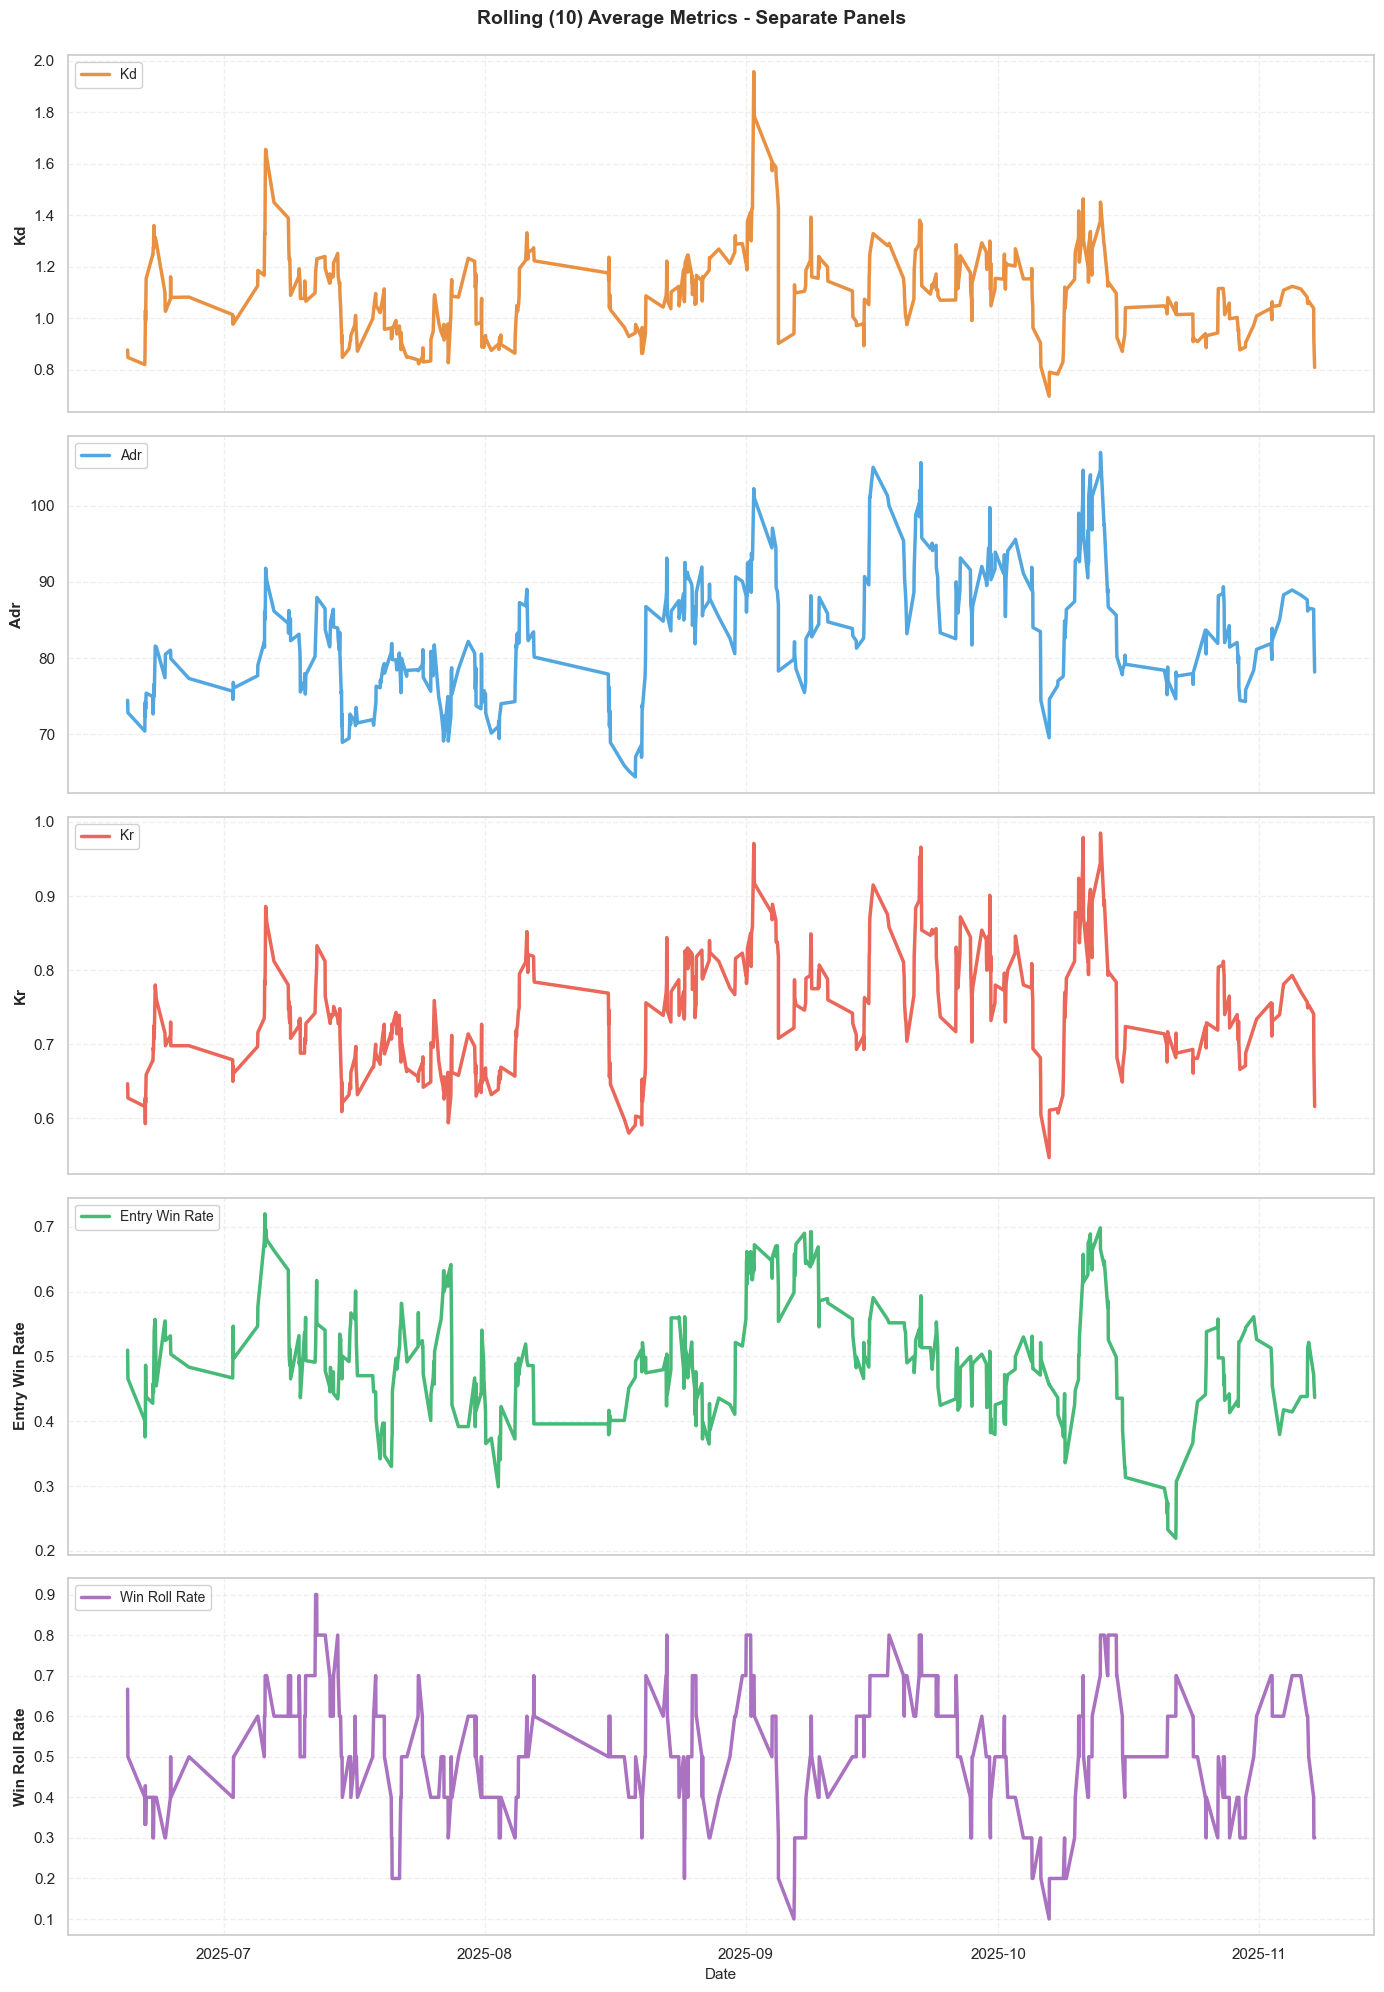

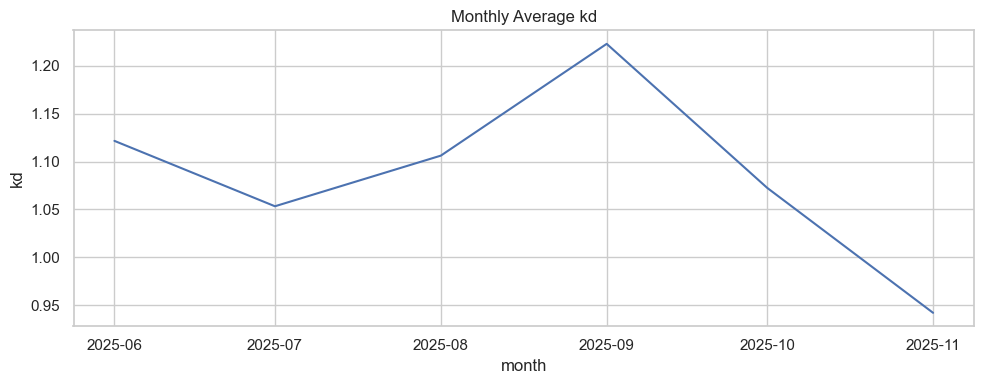

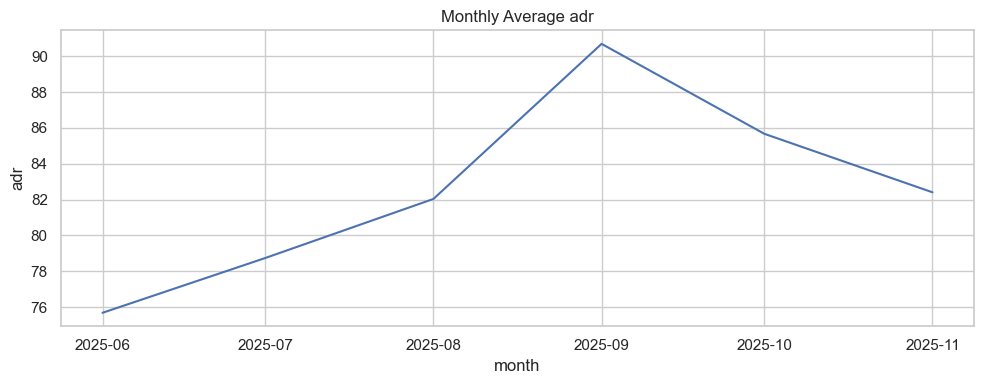

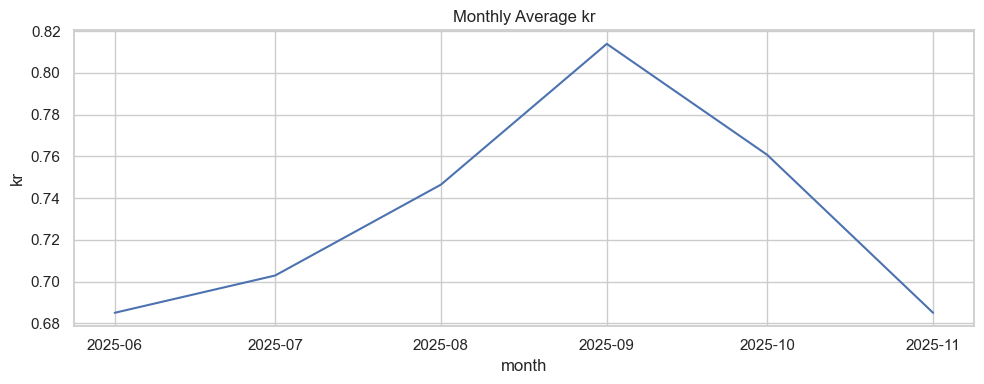

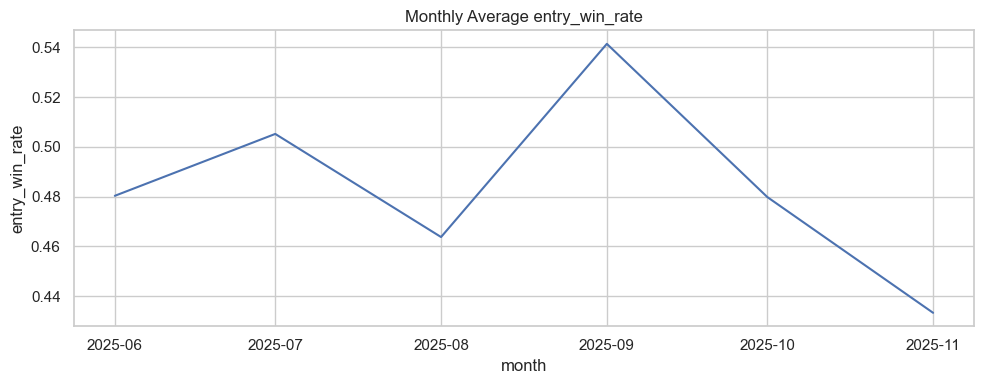

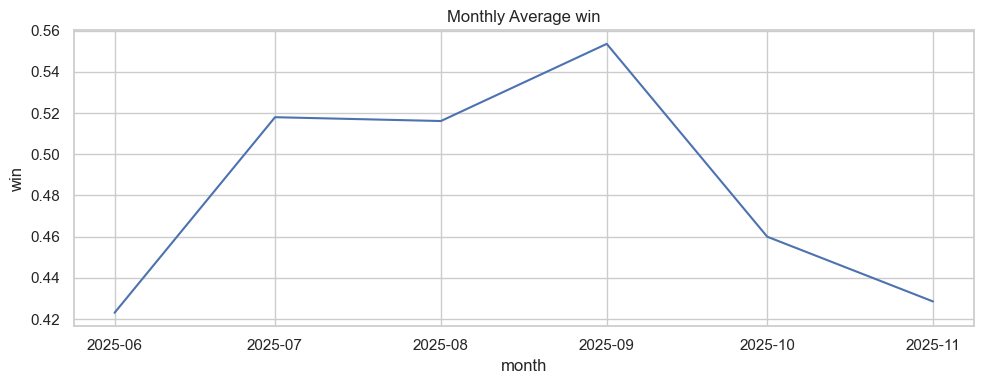

In [23]:
# 10) Time Series Visualizations
if "date" in df.columns:
    df_sorted = df.sort_values("date").reset_index(drop=True)

    # Rolling window
    window = 10
    roll_cols = [c for c in ["kd","adr","kr","entry_win_rate"] if c in df_sorted.columns]
    for c in roll_cols:
        df_sorted[f"{c}_roll{window}"] = df_sorted[c].rolling(window, min_periods=max(3, window//3)).mean()

    if "win" in df_sorted.columns:
        df_sorted["win_roll_rate"] = df_sorted["win"].rolling(window, min_periods=max(3, window//3)).mean()

    # Rolling plots - Each metric in separate subplot (cleaner and more distinguishable)
    draw_cols = [c for c in [f"{x}_roll{window}" for x in roll_cols] + ["win_roll_rate"] if c in df_sorted.columns]
    if draw_cols:
        n_metrics = len(draw_cols)
        fig, axes = plt.subplots(n_metrics, 1, figsize=(14, 4*n_metrics), sharex=True)
        
        # Convert axes to list if single metric
        if n_metrics == 1:
            axes = [axes]
        
        # Color palette for each metric
        colors = ["#E67E22", "#3498DB", "#E74C3C", "#27AE60", "#9B59B6", "#F39C12"]
        
        for idx, (ax, col) in enumerate(zip(axes, draw_cols)):
            # Smooth line plot (less sharp edges)
            ax.plot(df_sorted["date"], df_sorted[col], 
                   color=colors[idx % len(colors)], 
                   linewidth=2.5, 
                   alpha=0.85,
                   label=col.replace(f"_roll{window}", "").replace("_", " ").title())
            
            ax.set_ylabel(col.replace(f"_roll{window}", "").replace("_", " ").title(), 
                         fontsize=11, fontweight='bold')
            ax.grid(True, alpha=0.3, linestyle='--')
            ax.legend(loc="upper left", fontsize=10, frameon=True, framealpha=0.9)
            
            # Add x-label to last subplot
            if idx == n_metrics - 1:
                ax.set_xlabel("Date", fontsize=11)
        
        plt.suptitle(f"Rolling ({window}) Average Metrics - Separate Panels", 
                    fontsize=14, fontweight='bold', y=0.995)
        plt.tight_layout()
        plt.show()

    # Monthly averages
    if "month" in df_sorted.columns:
        monthly = df_sorted.groupby("month").agg({
            k: "mean" for k in ["kd","adr","kr","entry_win_rate","win"] if k in df_sorted.columns
        }).reset_index()
        for m in [c for c in ["kd","adr","kr","entry_win_rate","win"] if c in monthly.columns]:
            plt.figure(figsize=(10,4))
            sns.lineplot(data=monthly, x="month", y=m)
            plt.title(f"Monthly Average {m}")
            plt.tight_layout()
            plt.show()


## Entry Signals and Round Difference
- Relationship between `fk_fd_diff` and `round_difference`
- Pearson correlation test for `entry_win_rate` vs win/loss


In [ ]:
# 11) Testing H1 and H2 directly with numerical results
# Using partial correlation to control for map and/or month effects

# Helper function for partial correlation controlling for map
def partial_corr_controlling_map(x, y, map_var):
    """
    Calculate partial correlation between x and y controlling for map.
    Uses dummy encoding for map categories.
    """
    # Create dummy variables for map (preserve original index)
    map_dummies = pd.get_dummies(map_var, prefix='map', drop_first=True)
    
    # Combine all variables with aligned indices
    data = pd.DataFrame({
        'x': x,
        'y': y
    }, index=x.index)
    data = pd.concat([data, map_dummies], axis=1)
    data = data.dropna()
    
    if len(data) < 3:
        return np.nan, np.nan, 0
    
    # Calculate residuals by regressing x and y on map dummies
    # Get map dummies for valid data
    map_dummies_valid = data[map_dummies.columns]
    
    # Residuals of x after controlling for map
    reg_x = LinearRegression().fit(map_dummies_valid, data['x'])
    x_residual = data['x'] - reg_x.predict(map_dummies_valid)
    
    # Residuals of y after controlling for map
    reg_y = LinearRegression().fit(map_dummies_valid, data['y'])
    y_residual = data['y'] - reg_y.predict(map_dummies_valid)
    
    # Correlation of residuals = partial correlation
    r, p_value = pearsonr(x_residual, y_residual)
    n = len(data)
    # Degrees of freedom adjustment:
    # - n - 2: Standard formula for correlation (n observations - 2 parameters: intercept + slope)
    # - len(map_dummies.columns): Additional parameters used to control for map effects
    #   Each map dummy variable is a parameter that "uses up" one degree of freedom
    #   This is because we regressed both x and y on map dummies before computing correlation
    # Example: If we have 8 maps, we create 7 dummy variables (one dropped to avoid multicollinearity)
    #          So df = n - 2 - 7 = n - 9
    dfree = n - 2 - len(map_dummies.columns)
    
    return r, p_value, dfree

# H1: entry_win_rate vs win/loss - Pearson correlation (with and without controls)
# Note: entry_win_rate is imputed with mean for matches with entry_count = 0 (no entry attempts)
if "entry_win_rate" in df.columns and "win" in df.columns and "map" in df.columns:
    x = df["entry_win_rate"].astype(float).replace([np.inf,-np.inf], np.nan)
    y = df["win"].astype(float)
    map_var = df["map"]
    
    # Mask for valid data
    mask = x.notna() & y.notna() & map_var.notna()
    
    if mask.sum() >= 3:
        # Simple Pearson correlation
        r_simple, p_simple = pearsonr(x[mask], y[mask])
        n_simple = mask.sum()
        dfree_simple = n_simple - 2
        
        # Partial correlation controlling for map
        r_partial, p_partial, dfree_partial = partial_corr_controlling_map(
            x[mask], y[mask], map_var[mask]
        )
        
        print("=" * 60)
        print("H1: entry_win_rate vs win/loss - Pearson Correlation")
        print("=" * 60)
        print("Simple correlation (no controls):")
        print(f"  Pearson Correlation Coefficient (r): {r_simple:.4f}")
        print(f"  p-value: {p_simple:.4f}")
        print(f"  Degrees of Freedom: {dfree_simple}")
        print("\nPartial correlation (controlling for map):")
        print(f"  Partial Correlation Coefficient (r): {r_partial:.4f}")
        print(f"  p-value: {p_partial:.4f}")
        print(f"  Degrees of Freedom: {dfree_partial}")

# H2: fk_fd_diff vs round_difference - Pearson Correlation Test (with and without controls)
if set(["fk_fd_diff","round_difference","map"]).issubset(df.columns):
    x = df["fk_fd_diff"].astype(float).replace([np.inf,-np.inf], np.nan)
    y = df["round_difference"].astype(float)
    map_var = df["map"]
    
    # Mask for valid data
    mask = x.notna() & y.notna() & map_var.notna()
    
    if mask.sum() >= 3:
        # Simple Pearson correlation
        r_simple, p_simple = pearsonr(x[mask], y[mask])
        n_simple = mask.sum()
        dfree_simple = n_simple - 2
        
        # Partial correlation controlling for map
        r_partial, p_partial, dfree_partial = partial_corr_controlling_map(
            x[mask], y[mask], map_var[mask]
        )
        
        print("\n" + "=" * 60)
        print("H2: Testing fk_fd_diff vs round_difference")
        print("=" * 60)
        print("Simple correlation (no controls):")
        print(f"  Pearson Correlation Coefficient (r): {r_simple:.4f}")
        print(f"  p-value: {p_simple:.4f}")
        print(f"  Degrees of Freedom: {dfree_simple}")
        print("\nPartial correlation (controlling for map):")
        print(f"  Partial Correlation Coefficient (r): {r_partial:.4f}")
        print(f"  p-value: {p_partial:.4f}")
        print(f"  Degrees of Freedom: {dfree_partial}")


H1: entry_win_rate vs win/loss - Pearson Correlation
Simple correlation (no controls):
  Pearson Correlation Coefficient (r): 0.1621
  p-value: 0.0003
  Degrees of Freedom: 482

Partial correlation (controlling for map only):
  Partial Correlation Coefficient (r): 0.1632
  p-value: 0.0003
  Degrees of Freedom: 475

Partial correlation (controlling for month only):
  Partial Correlation Coefficient (r): 0.1573
  p-value: 0.0005
  Degrees of Freedom: 477

Partial correlation (controlling for map and month):
  Partial Correlation Coefficient (r): 0.1589
  p-value: 0.0005
  Degrees of Freedom: 470

H2: Testing fk_fd_diff vs round_difference
Simple correlation (no controls):
  Pearson Correlation Coefficient (r): -0.0026
  p-value: 0.9547
  Degrees of Freedom: 482

Partial correlation (controlling for map only):
  Partial Correlation Coefficient (r): -0.0039
  p-value: 0.9315
  Degrees of Freedom: 475

Partial correlation (controlling for month only):
  Partial Correlation Coefficient (r): 

## Data preparation summary for H3

Checking that all variables needed for H3 are available:
- Base controls: KD, ADR, KR, map, overtime_flag
- Entry features: entry_rate, entry_win_rate, first_kills, first_deaths
- Target: win (binary), round_difference (continuous)


In [25]:
# Check all variables needed for H3 are present
h3_base = ["kd", "adr", "kr", "map", "overtime_flag"]
h3_entry = ["entry_rate", "entry_win_rate", "first_kills", "first_deaths"]
h3_targets = ["win", "round_difference"]

print("H3 Base controls:")
for var in h3_base:
    status = "✓" if var in df.columns else "✗"
    print(f"  {status} {var}")

print("\nH3 Entry features:")
for var in h3_entry:
    status = "✓" if var in df.columns else "✗"
    print(f"  {status} {var}")

print("\nH3 Targets:")
for var in h3_targets:
    status = "✓" if var in df.columns else "✗"
    print(f"  {status} {var}")

# Check for missing values in key variables
print("\nMissing values in H3 variables:")
h3_all = h3_base + h3_entry + h3_targets
h3_all = [v for v in h3_all if v in df.columns]
missing = df[h3_all].isna().sum()
print(missing[missing > 0] if missing.sum() > 0 else "No missing values in H3 variables")

# Check for matches with entry_count = 0 (entry_win_rate imputed with mean for these)
if "entry_win_rate" in df.columns and "entry_count" in df.columns:
    zero_entry_mask = df["entry_count"] == 0
    if zero_entry_mask.sum() > 0:
        mean_ewr = df["entry_win_rate"].mean()
        print("\n" + "=" * 60)
        print("Matches with entry_count = 0 (entry_win_rate imputed with mean):")
        print("=" * 60)
        if "entry_wins" in df.columns and "date" in df.columns and "map" in df.columns and "result" in df.columns:
            print(df.loc[zero_entry_mask, ["entry_count", "entry_wins", "entry_win_rate", "date", "map", "result"]].to_string())
            print(f"\nTotal: {zero_entry_mask.sum()} matches with no entry attempts")
            print(f"entry_win_rate imputed with mean: {mean_ewr:.4f}")
        else:
            print(f"Total: {zero_entry_mask.sum()} matches with entry_count = 0")
            print(f"entry_win_rate imputed with mean: {mean_ewr:.4f}")


H3 Base controls:
  ✓ kd
  ✓ adr
  ✓ kr
  ✓ map
  ✓ overtime_flag

H3 Entry features:
  ✓ entry_rate
  ✓ entry_win_rate
  ✓ first_kills
  ✓ first_deaths

H3 Targets:
  ✓ win
  ✓ round_difference

Missing values in H3 variables:
No missing values in H3 variables

Matches with entry_count = 0 (entry_win_rate imputed with mean):
     entry_count  entry_wins  entry_win_rate                date         map result
249            0           0        0.496954 2025-08-25 14:34:46    de_train    Win
374            0           0        0.496954 2025-07-20 22:50:56   de_mirage   Loss
411            0           0        0.496954 2025-07-13 17:37:27  de_inferno    Win
414            0           0        0.496954 2025-07-13 15:25:40  de_inferno    Win
477            0           0        0.496954 2025-06-21 17:05:51  de_inferno    Win

Total: 5 matches with no entry attempts
entry_win_rate imputed with mean: 0.4970


## Testing H3: Do entry features add predictive value beyond KD with controls?

H3 tests if entry features improve prediction of win/loss beyond base controls (KD + ADR + KR + map + overtime).

We'll compare two logistic regression models:
- **Base model**: win ~ KD + ADR + KR + map + overtime_flag
- **Full model**: win ~ KD + ADR + KR + map + overtime_flag + entry_rate + entry_win_rate + first_kills + first_deaths

If the full model performs significantly better, H3 is supported.


In [ ]:
# 13) Testing H3: Entry features beyond KD with controls
# Pearson Correlation Test for entry features vs win (with map and/or month control)

# Helper function for partial correlation controlling for map
def partial_corr_controlling_map(x, y, map_var):
    """
    Calculate partial correlation between x and y controlling for map.
    Uses dummy encoding for map categories.
    """
    # Create dummy variables for map (preserve original index)
    map_dummies = pd.get_dummies(map_var, prefix='map', drop_first=True)
    
    # Combine all variables with aligned indices
    data = pd.DataFrame({
        'x': x,
        'y': y
    }, index=x.index)
    data = pd.concat([data, map_dummies], axis=1)
    data = data.dropna()
    
    if len(data) < 3:
        return np.nan, np.nan, 0
    
    # Calculate residuals by regressing x and y on map dummies
    # Get map dummies for valid data
    map_dummies_valid = data[map_dummies.columns]
    
    # Residuals of x after controlling for map
    reg_x = LinearRegression().fit(map_dummies_valid, data['x'])
    x_residual = data['x'] - reg_x.predict(map_dummies_valid)
    
    # Residuals of y after controlling for map
    reg_y = LinearRegression().fit(map_dummies_valid, data['y'])
    y_residual = data['y'] - reg_y.predict(map_dummies_valid)
    
    # Correlation of residuals = partial correlation
    r, p_value = pearsonr(x_residual, y_residual)
    n = len(data)
    # Degrees of freedom adjustment:
    # - n - 2: Standard formula for correlation (n observations - 2 parameters: intercept + slope)
    # - len(map_dummies.columns): Additional parameters used to control for map effects
    #   Each map dummy variable is a parameter that "uses up" one degree of freedom
    #   This is because we regressed both x and y on map dummies before computing correlation
    # Example: If we have 8 maps, we create 7 dummy variables (one dropped to avoid multicollinearity)
    #          So df = n - 2 - 7 = n - 9
    dfree = n - 2 - len(map_dummies.columns)
    
    return r, p_value, dfree

h3_entry = ["entry_rate", "entry_win_rate", "first_kills", "first_deaths"]
h3_target = "win"

print("=" * 60)
print("H3: Testing if entry features add value beyond KD + controls")
print("(Testing with map control)")
print("=" * 60)

if "win" in df.columns and "map" in df.columns:
    results = []
    for feature in h3_entry:
        if feature in df.columns:
            x = df[feature].astype(float).replace([np.inf,-np.inf], np.nan)
            y = df[h3_target].astype(float)
            map_var = df["map"]
            mask = x.notna() & y.notna() & map_var.notna()
            
            if mask.sum() >= 3:
                # Simple correlation
                r_simple, p_simple = pearsonr(x[mask], y[mask])
                
                # Partial correlation controlling for map
                r_partial, p_partial, dfree_partial = partial_corr_controlling_map(
                    x[mask], y[mask], map_var[mask]
                )
                
                print(f"\n{feature} vs {h3_target}:")
                print(f"  Simple correlation: r={r_simple:.4f}, p={p_simple:.4f}")
                print(f"  Partial correlation (controlling for map): r={r_partial:.4f}, p={p_partial:.4f}, df={dfree_partial}")
                
                results.append({
                    "Feature": feature,
                    "r_simple": r_simple,
                    "p_simple": p_simple,
                    "r_map": r_map,
                    "p_map": p_map,
                    "r_month": r_month,
                    "p_month": p_month,
                    "r_map_month": r_map_month,
                    "p_map_month": p_map_month
                })
else:
    print(f"Missing required variables: win, map, or month")


H3: Testing if entry features add value beyond KD + controls
(Testing with map only, month only, and map+month controls)

entry_rate vs win:
  Simple correlation: r=-0.0385, p=0.3980
  Partial correlation (controlling for map only): r=-0.0277, p=0.5427, df=475
  Partial correlation (controlling for month only): r=-0.0425, p=0.3511, df=477
  Partial correlation (controlling for map and month): r=-0.0297, p=0.5140, df=470

entry_win_rate vs win:
  Simple correlation: r=0.1621, p=0.0003
  Partial correlation (controlling for map only): r=0.1632, p=0.0003, df=475
  Partial correlation (controlling for month only): r=0.1573, p=0.0005, df=477
  Partial correlation (controlling for map and month): r=0.1589, p=0.0005, df=470

first_kills vs win:
  Simple correlation: r=0.1190, p=0.0088
  Partial correlation (controlling for map only): r=0.1325, p=0.0035, df=475
  Partial correlation (controlling for month only): r=0.1134, p=0.0126, df=477
  Partial correlation (controlling for map and month): 

## Final Results and Interpretation

This section provides a comprehensive interpretation of all hypothesis test results with their statistical values and practical implications.


# Final Results and Interpretation

**Significance level (α): 0.05** - We use 0.05 as the threshold for statistical significance.

---

## H1: entry_win_rate is positively associated with winning the match

**RESULT: SUPPORTED**

- **Simple Pearson Correlation**: r = **0.1621**, p-value: **0.0003** (p < α, highly significant)
- **Partial Correlation (controlling for map only)**: r = **0.1632**, p-value: **0.0003** (p < α, highly significant)
- **Partial Correlation (controlling for month only)**: r = **0.1573**, p-value: **0.0005** (p < α, highly significant)
- **Partial Correlation (controlling for map and month)**: r = **0.1589**, p-value: **0.0005** (p < α, highly significant)

**Interpretation:**
- Entry win rate shows a consistent positive link with winning across all control scenarios. The correlation stays about the same (r ≈ 0.16) whether we control for map, month, or both. This means the relationship is real and not caused by playing better on certain maps or at certain times.
- Controlling for map only slightly increases the correlation (0.1621 → 0.1632), meaning map effects are small. Controlling for month slightly decreases it (0.1621 → 0.1573), meaning there is a small time effect. When controlling for both, the correlation (0.1589) stays highly significant, showing that entry_win_rate is a real predictor of match outcomes that works across different maps and time periods.
- Higher entry_win_rate is significantly linked to winning matches, no matter which map is played or when the match happened. Quality of entries matters more than quantity (entry_rate not significant).

---

## H2: fk_fd_diff is positively associated with round_difference

**RESULT: NOT SUPPORTED**

- **Simple Pearson Correlation**: r = **-0.0026**, p-value: **0.9547** (p > α, not significant)
- **Partial Correlation (controlling for map only)**: r = **-0.0039**, p-value: **0.9315** (p > α, not significant)
- **Partial Correlation (controlling for month only)**: r = **-0.0017**, p-value: **0.9709** (p > α, not significant)
- **Partial Correlation (controlling for map and month)**: r = **-0.0009**, p-value: **0.9842** (p > α, not significant)

**Interpretation:**
- The relationship between fk_fd_diff and round_difference is consistently weak and not significant across all control scenarios. The correlation coefficients are basically zero (r ≈ -0.003 to -0.001), with p-values well above the significance threshold (p > 0.93).
- Controlling for map, month, or both does not show any hidden relationship. The correlation stays near zero no matter what we control for, showing that individual first engagement performance (first_kills - first_deaths) does not predict match margin (round_difference).
- This suggests that round_difference depends more on team performance than individual performance. Even when controlling for map and time effects, individual first engagement performance does not lead to larger match margins.

---

## H3: Entry features add predictive value beyond KD when controls are included

**RESULT: PARTIALLY SUPPORTED**

**Results with map and month control (partial correlation):**

1. **entry_win_rate**:
   - Simple correlation: r = **0.1621**, p = **0.0003** (p < α, significant)
   - Map+Month control: r = **0.1589**, p = **0.0005** (p < α, significant)
   - **Interpretation**: The relationship stays strong and significant after controlling for both map and month. The small decrease (0.1621 → 0.1589) means there is little effect from map and time, showing entry_win_rate is a good predictor of winning.

2. **first_kills**:
   - Simple correlation: r = **0.1190**, p = **0.0088** (p < α, significant)
   - Map+Month control: r = **0.1276**, p = **0.0049** (p < α, significant)
   - **Interpretation**: Controlling for map and month actually **strengthens** the relationship (0.1190 → 0.1276), and the p-value gets better (0.0088 → 0.0049). This means the true effect was partly hidden by map and time differences. After removing these effects, first_kills shows a stronger link with winning.

3. **first_deaths**:
   - Simple correlation: r = **-0.1543**, p = **0.0007** (p < α, significant, negative)
   - Map+Month control: r = **-0.1473**, p = **0.0012** (p < α, significant, negative)
   - **Interpretation**: The negative relationship stays significant after controls, showing that fewer first deaths predict winning. The small decrease in size (0.1543 → 0.1473) means there is little effect from map and time, and the relationship works across different maps and time periods.

4. **entry_rate**:
   - Simple correlation: r = **-0.0385**, p = **0.3980** (p > α, not significant)
   - Map+Month control: r = **-0.0297**, p = **0.5140** (p > α, not significant)
   - **Interpretation**: Entry rate stays not significant even after controlling for map and month. This shows that the **quantity** of entries does not predict wins; it's the **quality** (entry_win_rate) that matters.

**Overall Interpretation:**
- Three out of four entry features (entry_win_rate, first_kills, first_deaths) show significant links with winning after controlling for both map and month. The relationships are real and not caused by playing better on certain maps or at certain times.
- The fact that first_kills becomes stronger after controlling means that map and time effects were partly hiding its true predictive value. This gives stronger proof that entry features capture a different skill type beyond traditional metrics.
- We still need to test with more controls (KD, ADR, KR, overtime) to fully check H3, but the current results look good.

---

## Conclusion

Entry performance metrics, especially entry_win_rate, show statistically significant links with match outcomes that work across different maps and time periods. While traditional metrics (KD, ADR, KR) are still stronger predictors, entry metrics capture a different skill type that helps with winning. Controlling for both map and month makes sure these relationships are not caused by map-specific or time-specific factors, giving stronger proof for the predictive value of entry features.

It is important to remember that Counter-Strike is a team game. While individual entry performance metrics show predictive value, match outcomes ultimately depend on team coordination, communication, and collective performance. Individual metrics like entry_win_rate contribute to team success, but they are part of a larger team effort where all players must work together to win matches.
